# MONTE CARLO TREE SEARCH

In [9]:
import numpy as np
import chess
import chess.pgn
import chess.engine
import chess.svg
import random

import io
import time
import torch
from torch.utils.data import Dataset, DataLoader
from IPython.display import display,SVG,clear_output 
from torchvision.transforms import ToTensor
from torch.utils.data import random_split

import torch.nn as nn
import torch.nn.functional as F

import math

import torch.optim as optim

import torchvision
import torchvision.datasets as datasets


from IPython.display import SVG, display

In [10]:
# Diccionarios
capa_pieza = {'p': 1, 'r': 3, 'n': 5, 'b': 7, 'q': 9, 'k': 11, 'P': 0, 'R': 2, 'N': 4, 'B': 6, 'Q': 8, 'K': 10}

numero_letra = {0: 'a', 1: 'b', 2: 'c', 3: 'd', 4: 'e', 5: 'f', 6: 'g', 7: 'h'}

letra_numero = {'a': 0, 'b': 1, 'c': 2, 'd':3 , 'e': 4, 'f': 5, 'g':6 , 'h': 7}


# representación tablero
def representacion_tablero(board,verbose=False):
    fen = board.fen().split()
    tablero_piezas_fen = fen[0]
    turno_fen = fen[1]
    enroque_fen = fen[2]
    enpassant_fen = fen[3]

    tablero_r = np.zeros((8,8,22),dtype=np.float32)

    fila=0
    columna=0
    
    for caracter in tablero_piezas_fen:
        
        if not caracter.isdigit():
         
            if caracter == '/':
                fila+=1
                columna=0
           
            else:
    
                tablero_r[fila][columna][capa_pieza[caracter]]=1
                columna+=1
                
        else:
            columna+= int(caracter)

    if turno_fen == 'w':
        tablero_r[:, :, 12] = 1
    if 'K' in enroque_fen:
        tablero_r[:, :, 13] = 1
    if 'k' in enroque_fen:
        tablero_r[:, :, 14] = 1
    if 'Q' in enroque_fen:
        tablero_r[:, :, 15] = 1
    if 'q' in enroque_fen:
        tablero_r[:, :, 16] = 1
           

    if enpassant_fen != "-":
        tablero_r[8-int(enpassant_fen[1])][letra_numero[enpassant_fen[0]]][17] = 1


    for square in chess.SQUARES:
        row = 7 - (square // 8)
        col = square % 8  
        tablero_r[row, col, 18] = len(board.attackers(chess.WHITE, square))/10
        tablero_r[row, col, 19] = len(board.attackers(chess.BLACK, square))/10

    for move in board.legal_moves:
        to_square = move.to_square
        row = 7 - (to_square // 8)
        col = to_square % 8
        tablero_r[row][col][20] = 1

    if board.is_check():
        tablero_r[:, :, 21] = 1


    if turno_fen == 'b':
        tablero_r = np.flip(tablero_r[:, :, :22], axis=(0, 1)).copy()

    if verbose:       
        for capa in range(22):
             for fila in range(8):
                 for columna in range(8):
                     print(tablero_r[fila][columna][capa], end="")
                     print(" ",end="")
                 print(" ")
             print("\n")



    return tablero_r



# representación movimiento
def move_to_policy(uci_move,turn,verbose=False):
    move = np.zeros((8,8,2),dtype=np.float32)
    casilla_origen = uci_move[:2]
    casilla_destino = uci_move[2:4]

    casilla_origen_columna = letra_numero[casilla_origen[0]]
    casilla_origen_fila = casilla_origen[1]
    
    casilla_destino_columna = letra_numero[casilla_destino[0]]
    casilla_destino_fila = casilla_destino[1]


    casilla_origen_fila = 8 - int(casilla_origen_fila)

    casilla_destino_fila = 8 - int(casilla_destino_fila)


    move[casilla_origen_fila][casilla_origen_columna][0]=1
    move[casilla_destino_fila][casilla_destino_columna][1]=1

    if turn != chess.WHITE:
        move = np.flip(move[:, :, :2], axis=(0, 1)).copy()

    if verbose:
        for capa in range(2):
             for fila in range(8):
                 for columna in range(8):
                     print(move[fila][columna][capa], end="")
                     print(" ",end="")
                 print(" ")
             print("\n")
        
        
    return move

In [11]:
class ResNet(nn.Module):
    def __init__(self, num_resBlocks, num_hidden):
        super().__init__()
        self.startBlock = nn.Sequential(
            nn.Conv2d(22, num_hidden, kernel_size=3, padding=1,bias=False),
            nn.BatchNorm2d(num_hidden),
            nn.ReLU()
        )
        
        self.backBone = nn.ModuleList(
            [ResBlock(num_hidden) for i in range(num_resBlocks)]
        )
        
        self.policyHead = nn.Sequential(
            nn.Conv2d(num_hidden, num_hidden, kernel_size=3,padding=1,bias=False),
            nn.BatchNorm2d(num_hidden),
            nn.ReLU(),
            nn.Conv2d(num_hidden, 2, kernel_size=3,padding=1),
        )

        self.valueHead = nn.Sequential(
            nn.Conv2d(num_hidden, 3, kernel_size=3,padding=1,bias=False),
            nn.BatchNorm2d(3),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(3 * 8 * 8, 1),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.startBlock(x)
        for resBlock in self.backBone:
            x = resBlock(x)
        policy = self.policyHead(x)
        value =  self.valueHead(x)
        return policy,value
    
class ResBlock(nn.Module):
    def __init__(self, num_hidden):
        super().__init__()
        self.conv1 = nn.Conv2d(num_hidden, num_hidden, kernel_size=3, padding=1,bias=False)
        self.bn1 = nn.BatchNorm2d(num_hidden)
        self.conv2 = nn.Conv2d(num_hidden, num_hidden, kernel_size=3, padding=1,bias=False)
        self.bn2 = nn.BatchNorm2d(num_hidden)
        
    def forward(self, x):
        residual = x
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.bn2(self.conv2(x))
        x += residual
        x = F.relu(x)
        return x

In [12]:
def softmax(x):
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum()
    
def obtener_distribucion(board,model,device):
    model.eval()
    input = representacion_tablero(board)

    transform = ToTensor()
    tablero_tensor = transform(input).unsqueeze(0)

    with torch.no_grad():  # Asegúrate de que no se realice el cálculo del gradiente
        tablero_tensor= tablero_tensor.to(device)
        outputs,eval = model(tablero_tensor)  # Realiza la predicción
    outputs = outputs.squeeze(0).detach().cpu().numpy()
    value= eval.cpu().item()

    movimientos_legales= [move.uci() for move in board.legal_moves]
    valores_mapa_activacion = []
    
    for uci_move in movimientos_legales:
              
        if board.turn == chess.WHITE:

            columna_inicial = letra_numero[uci_move[0]]
            fila_inicial = 8-int(uci_move[1])

            columna_final = letra_numero[uci_move[2]]
            fila_final = 8-int(uci_move[3])
                
        else:

            columna_inicial = 7-letra_numero[uci_move[0]]
            fila_inicial = 7-(8-int(uci_move[1]))

            columna_final = 7-letra_numero[uci_move[2]]
            fila_final = 7-(8-int(uci_move[3]))

        valores_mapa_activacion.append(outputs[0][fila_inicial][columna_inicial]+outputs[1][fila_final][columna_final])

    #valores_mapa_activacion /= np.sum(valores_mapa_activacion)
  

    valores_mapa_activacion = softmax(valores_mapa_activacion)

    return  valores_mapa_activacion,movimientos_legales,value



In [14]:
modelo = ResNet(10,256)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Cargar los pesos guardados
  
modelo.load_state_dict(torch.load("modelo_pesos.pth"))
modelo = modelo.to(device)

board = chess.Board()
obtener_distribucion(board,modelo,device)

(array([5.0987939e-05, 5.1253885e-03, 4.3979444e-04, 4.4760658e-05,
        3.4590680e-06, 3.3932687e-05, 9.4018849e-03, 4.2350221e-01,
        1.3251399e-02, 1.0658939e-03, 6.2709331e-04, 1.1080762e-05,
        5.1316852e-06, 3.0555877e-06, 5.3303712e-04, 4.6629962e-01,
        6.4917937e-02, 1.4605664e-02, 6.0630227e-05, 1.6999114e-05],
       dtype=float32),
 ['g1h3',
  'g1f3',
  'b1c3',
  'b1a3',
  'h2h3',
  'g2g3',
  'f2f3',
  'e2e3',
  'd2d3',
  'c2c3',
  'b2b3',
  'a2a3',
  'h2h4',
  'g2g4',
  'f2f4',
  'e2e4',
  'd2d4',
  'c2c4',
  'b2b4',
  'a2a4'],
 0.27170780301094055)

In [15]:
class Node:
    def __init__(self,prior,board,move=None):
        self.prior = prior
        self.visit_count= 0
        self.value_sum = 0
        self.children=[]
        self.board= board
        self.move = move

    def value(self):
        if self.visit_count == 0:
            return 0
        return self.value_sum / self.visit_count

    def is_expanded(self):
        return len(self.children)>0

    def expand(self,list_distribution,moves):
        
        for i,uci_move in enumerate(moves):

            
            move = chess.Move.from_uci(uci_move)
            board_child = self.board.copy()
            board_child.push(move)
            
            node = Node(list_distribution[i],board_child,uci_move)
            self.children.append(node)
            
            
    def print_values(self):
        print(self.move)
        print(self.visit_count)

    def select(self):

        mejor_ucb = -np.inf
        mejor_nodo= None
        for node in self.children:
            ucb_score = self.get_ucb_score(node)
            if ucb_score>mejor_ucb:
                mejor_ucb = ucb_score
                mejor_nodo = node
        return mejor_nodo
        

    def get_ucb_score(self,child):
        prior_score = child.prior *2 * math.sqrt(self.visit_count) / (child.visit_count + 1)
        if child.visit_count > 0:
          
            value_score = -child.value()
        else:
            value_score = 0

        return value_score + prior_score
        
        
            


class Chess_MCTS:
    def __init__(self, inicial_board,num_simulations,modelo,device):
        self.inicial_board= inicial_board
        self.simulations = num_simulations
        self.modelo = modelo
        self.device = device
        
    def iniciar(self):

        root = Node(1,self.inicial_board)
        
        for _ in range(self.simulations):

            node = root
            search_path = [node]

            #selection
            while node.is_expanded():
                node = node.select()
                search_path.append(node)

            terminada,value = partida_terminada(node.board)
            if not terminada:
                distribucion,movimientos,value = obtener_distribucion(node.board,self.modelo,self.device)
                node.expand(distribucion,movimientos)
            
            self.backpropagate(search_path, value)
        moves=[]
        distribution=[]
        for i,child in enumerate(root.children):
            moves.append(child.move)
            distribution.append(child.visit_count)
            #child.print_values()
        return moves,distribution,root.value()
        
            

    def backpropagate(self, search_path, value):
        oponente = 1
        for node in reversed(search_path):
            node.value_sum += value*oponente
            node.visit_count += 1
            oponente = oponente*-1


def partida_terminada(board):
    # Verificar si hay jaque mate
    if board.is_checkmate():
        return True,-1

    # Verificar si hay ahogado (stalemate)
    if board.is_stalemate():
        return True,0

    # Verificar si hay tablas por insuficiencia de material
    if board.is_insufficient_material():
        return True,0

    # Verificar regla de los 50 movimientos sin captura ni avance de peón
    if board.can_claim_fifty_moves():
        return True,0

    # Verificar regla de tres repeticiones
    if board.is_repetition(3):
        return True,0

    return False,0

['g1h3', 'g1f3', 'b1c3', 'b1a3', 'h2h3', 'g2g3', 'f2f3', 'e2e3', 'd2d3', 'c2c3', 'b2b3', 'a2a3', 'h2h4', 'g2g4', 'f2f4', 'e2e4', 'd2d4', 'c2c4', 'b2b4', 'a2a4']
[0, 0, 0, 0, 0, 0, 0, 347, 1, 0, 0, 0, 0, 0, 0, 107, 43, 1, 0, 0]
Negras
e2e3
0.40047497098171153


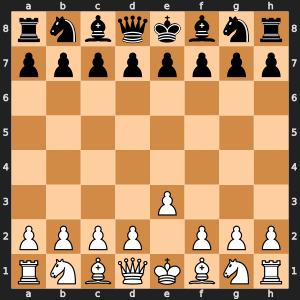

--------------------------------------------------


Turno de Negras. Ingrese su movimiento:  e7e5


Blancas
e7e5
-1


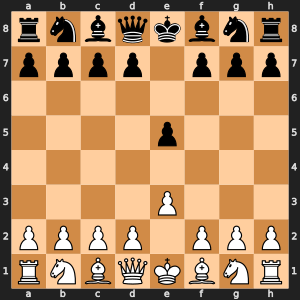

--------------------------------------------------
['g1h3', 'g1f3', 'g1e2', 'f1a6', 'f1b5', 'f1c4', 'f1d3', 'f1e2', 'e1e2', 'd1h5', 'd1g4', 'd1f3', 'd1e2', 'b1c3', 'b1a3', 'e3e4', 'h2h3', 'g2g3', 'f2f3', 'd2d3', 'c2c3', 'b2b3', 'a2a3', 'h2h4', 'g2g4', 'f2f4', 'd2d4', 'c2c4', 'b2b4', 'a2a4']
[0, 101, 0, 0, 0, 17, 0, 0, 0, 0, 0, 0, 0, 23, 0, 0, 0, 0, 6, 14, 169, 0, 0, 0, 0, 0, 162, 7, 0, 0]
Negras
c2c3
0.4478726345943287


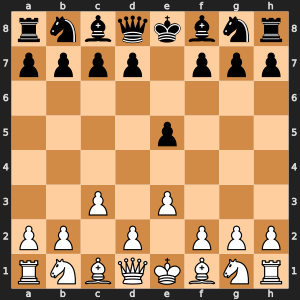

--------------------------------------------------


Turno de Negras. Ingrese su movimiento:  d7d5


Blancas
d7d5
-1


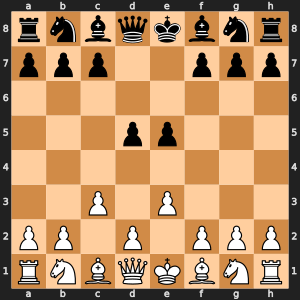

--------------------------------------------------
['g1h3', 'g1f3', 'g1e2', 'f1a6', 'f1b5', 'f1c4', 'f1d3', 'f1e2', 'e1e2', 'd1h5', 'd1g4', 'd1a4', 'd1f3', 'd1b3', 'd1e2', 'd1c2', 'b1a3', 'e3e4', 'c3c4', 'h2h3', 'g2g3', 'f2f3', 'd2d3', 'b2b3', 'a2a3', 'h2h4', 'g2g4', 'f2f4', 'd2d4', 'b2b4', 'a2a4']
[0, 209, 4, 0, 2, 7, 81, 12, 0, 0, 0, 0, 25, 0, 0, 0, 0, 6, 0, 0, 0, 11, 12, 0, 0, 0, 0, 0, 130, 0, 0]
Negras
g1f3
0.37445134225906807


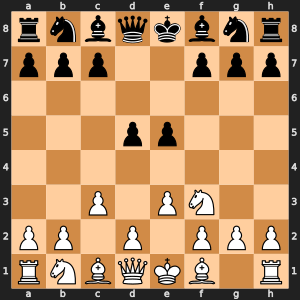

--------------------------------------------------


KeyboardInterrupt: Interrupted by user

In [19]:
class BotMonteCarlo:
    def __init__(self,simulaciones,modelo,device):

        self.simulaciones = simulaciones
        self.modelo = modelo
        self.device= device

     
    def obtener_movimiento(self,board):

        mc = Chess_MCTS(board,self.simulaciones,self.modelo,self.device)
        moves,distribution,value=mc.iniciar()
        print(moves)
        print(distribution)
        index_max=distribution.index(max(distribution))
        move = chess.Move.from_uci(moves[index_max])

        return move,value

class Jugador:
    def __init__(self, nombre):
        self.nombre = nombre

    def obtener_movimiento(self,board):
        # Obtener todos los movimientos legales posibles en el tablero dado
     
        move = input(f"Turno de {'Blancas' if board.turn == chess.WHITE else 'Negras'}. Ingrese su movimiento: ")

        move = chess.Move.from_uci(move)
          
        return move,-1



class Partida:
    def __init__(self, jugadorBlancas, jugadorNegras):
        self.jugador1 = jugadorBlancas
        self.jugador2 = jugadorNegras
        self.board = chess.Board()

    def realizar_partida(self,verbose=False):
        while not self.board.is_game_over():
           
            if self.board.turn == chess.WHITE:
                move,eval = jugadorBlancas.obtener_movimiento(self.board)
                
            else:
                move,eval = jugadorNegras.obtener_movimiento(self.board)

            self.board.push(move)
            if verbose:

                if self.board.turn == chess.WHITE:
                    print("Blancas")
                else:
                    print("Negras")
                print(move)
                print(eval)
                svg_content = chess.svg.board(board=self.board,size=300)
                display(SVG(svg_content))
                print("--------------------------------------------------")
            
        
        resultado = self.board.result()
        if resultado == "1-0":  # Blancas ganan
            return 1
        elif resultado == "0-1":  # Negras ganan
            return -1
        else:
            return 0 


modelo = ResNet(10, 256)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  
modelo.load_state_dict(torch.load("modelo_pesos.pth"))
modelo = modelo.to(device)

board=chess.Board()

jugadorBlancas =BotMonteCarlo(500,modelo,device)

jugadorNegras = Jugador("Marc")

partida = Partida(jugadorBlancas, jugadorNegras)
resultado = partida.realizar_partida(True)